In [2]:
import itertools
import yaml
from yaml.loader import SafeLoader
import mlflow
import mlflow.pyfunc
import joblib
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sdv.evaluation.single_table import run_diagnostic
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import get_column_pair_plot
from sdv.evaluation.single_table import evaluate_quality
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

os.chdir('/home/onyxia/work/synthetic-data-sdc/')
os.environ["MLFLOW_TRACKING_URI"] = "https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/" 

In [3]:
variables = ['sex','age','agegr','placesize','edu','socprof','marital','ls','depress','trust','trustfam','trustneigh','sport','nofriend','smoke','alcabuse','alcsol','wkabint','englang','height','weight','bmi']

In [4]:
original = pd.read_csv('SDV/df_original.csv', names = variables)

In [5]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(original)

In [9]:
with open("SDV/config_ctgan.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

class CTGANWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self):
        self.model = None

    def load_context(self, context):
        self.model = joblib.load(context.artifacts["model_path"])

    def predict(self, context, model_input):
        return self.model.sample(len(model_input))


In [18]:
run_name = 'ctgan_sd2011_dlr' + str(config['discriminator_lr']) + '_glr' + str(config['generator_lr']) + '_b' + str(config['batch_size']) + '_e' + str(config['epochs']) + '_gpu'


In [10]:

start_time = time.time()
ctgan = CTGANSynthesizer(metadata, 
                         verbose=False,
                         discriminator_lr=config['discriminator_lr'],
                         generator_lr=config['generator_lr'],
                         batch_size=config['batch_size'],
                         epochs = config['epochs'],
                         cuda = True)
ctgan.fit(original)
end_time = time.time()
ctgan.save(run_name + '.pkl')

/opt/conda/lib/python3.12/site-packages/sdv/single_table/base.py:97: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Text(0.5, 1.0, "Loss d'un modèle TVAE sur SD2011")

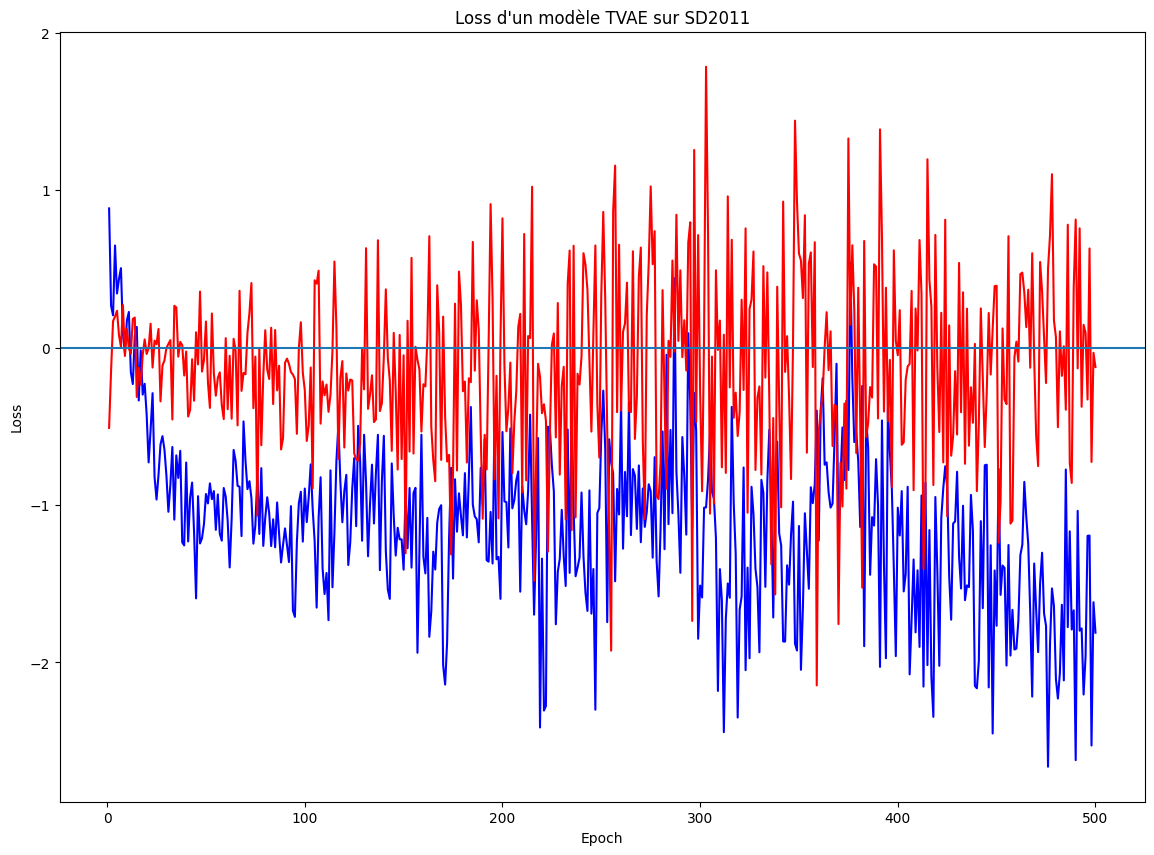

In [17]:
steps = range(1, config['epochs']+1)

plt.figure(figsize=(14, 10))

plt.plot(steps, ctgan.get_loss_values()['Generator Loss'], color='blue', label = "Generator")
plt.plot(steps, ctgan.get_loss_values()['Discriminator Loss'], color='red', label = "Discriminator")
plt.axhline(0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss d'un modèle TVAE sur SD2011")

## Variabilité du modèle

In [23]:
with open("SDV/config_ctgan.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

In [ ]:
remote_server_uri = os.environ["MLFLOW_TRACKING_URI"]
experiment_name = 'Default'

all_gen_loss_by_epoch = {'epoch': [i for i in range(config['epochs'])]}
all_dis_loss_by_epoch = {'epoch': [i for i in range(config['epochs'])]}

for i in range(10):
    if (i+1)%10 == 0:
        print(i+1)
    run_name = 'ctgan_sd2011_dlr' + str(config['discriminator_lr']) + '_glr' + str(config['generator_lr']) + '_b' + str(config['batch_size']) + '_e' + str(config['epochs']) + '_iter' + str(i) + '_gpu'
    
    mlflow.set_tracking_uri(remote_server_uri)
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=run_name):
        for param_key, param_value in config.items():
            if param_key != 'mlflow':
                mlflow.log_param(param_key, param_value)
        mlflow.log_param('run_name', run_name)
    
        #Entraînement
        start_time = time.time()
        ctgan = CTGANSynthesizer(metadata,
                                verbose=False,
                                discriminator_lr=config['discriminator_lr'],
                                generator_lr=config['generator_lr'],
                                batch_size=config['batch_size'],
                                epochs = config['epochs'])
        ctgan.fit(original)
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        mlflow.log_metric("elapsed_time", elapsed_time)
        print(f"Temps pris entraîner le modèle : {elapsed_time} secondes")
        
        params_ctgan = ctgan.get_parameters()
       
    
        # Log des paramètres du modèle
        for param_key, param_value in params_ctgan.items():
            with mlflow.start_run(nested=True):
                mlflow.log_param(param_key, param_value)
    
        gen_loss_by_epoch = ctgan.get_loss_values()['Generator Loss'].tolist()
        dis_loss_by_epoch = ctgan.get_loss_values()['Discriminator Loss'].tolist()
        
        nom_iter = 'iter'+str(i)
        all_gen_loss_by_epoch[nom_iter] = gen_loss_by_epoch
        all_dis_loss_by_epoch[nom_iter] = dis_loss_by_epoch
        
        for epoch, loss in enumerate(gen_loss_by_epoch):
            mlflow.log_metric("generator_loss", loss, step=epoch)
            
        for epoch, loss in enumerate(dis_loss_by_epoch):
            mlflow.log_metric("discriminator_loss", loss, step=epoch)
    
    
        model_path = run_name + ".pkl"
        joblib.dump(ctgan, model_path)
        mlflow.pyfunc.log_model(
            artifact_path="ctgan_model",
            python_model=CTGANWrapper(),
            artifacts={"model_path": model_path},
        )
        mlflow.log_artifact("SDV/config_ctgan.yml", artifact_path = "config_model")
        
    mlflow.end_run()